<div style="border:solid green 2px; padding: 20px">
<b>Привет, Михаил!</b>

Меня зовут Александр Пономаренко, и я буду проверять твой проект. Предлагаю общаться на «ты» :) Но если это не удобно - дай знать, и мы перейдем на "вы". 

Моя основная цель — не указать на совершенные тобою ошибки, а поделиться своим опытом и помочь тебе стать data science. Ты уже проделал большую работу над проектом, но давай сделаем его еще лучше. Ниже ты найдешь мои комментарии - **пожалуйста, не перемещай, не изменяй и не удаляй их**. Увидев у тебя ошибку, в первый раз я лишь укажу на ее наличие и дам тебе возможность самой найти и исправить ее. На реальной работе твой начальник будет поступать так же, а я пытаюсь подготовить тебя именно к работе аналитиком. Но если ты пока не справишься с такой задачей - при следующей проверке я дам более точную подсказку. Я буду использовать цветовую разметку:

<div class="alert alert-danger">
<b>Комментарий ревьюера ❌:</b> Так выделены самые важные замечания. Без их отработки проект не будет принят. </div>

<div class="alert alert-warning">
<b>Комментарий ревьюера ⚠️:</b> Так выделены небольшие замечания. Я надеюсь, что их ты тоже учтешь - твой проект от этого станет только лучше. Но настаивать на их отработке не буду.

</div>

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Так я выделяю все остальные комментарии.</div>

Давай работать над проектом в диалоге: **если ты что-то меняешь в проекте или отвечаешь на мои комменатри — пиши об этом.** Мне будет легче отследить изменения, если ты выделишь свои комментарии:
<div class="alert alert-info"> <b>Комментарий студента:</b> Например, вот так.</div>

Всё это поможет выполнить повторную проверку твоего проекта оперативнее. 

<div class="alert alert-info">
<b>Комментарий студента:</b> Привет, Александр!
    
- Должно быть ты хотел написать "data scientist".
- Ну я уже работаю, и мой начальник так не делает)))
- Аналитиком работать я не хочу, скорее ML-инженером.
</div>

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
import catboost
import lightgbm

import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split

In [2]:
RANDOM_STATE = 42

## Подготовка данных

In [3]:
data = pd.read_csv(
    'datasets/autos.csv',
    usecols=[
        # 'DateCrawled',  # неинформативный признак
        'Price',
        'VehicleType',
        'RegistrationYear',
        'Gearbox',
        'Power',
        'Model',
        'Kilometer',
        'RegistrationMonth',
        'FuelType',
        'Brand',
        'Repaired',
        # 'DateCreated',  # неинформативный признак
        # 'NumberOfPictures',  # неинформативный признак (везде 0)
        # 'PostalCode',  # неинформативный признак
        'LastSeen',
    ],
)

data = data.rename(columns={
    'Price': 'price',
    'VehicleType': 'vehicle_type',
    'RegistrationYear': 'registration_year',
    'Gearbox': 'gearbox',
    'Power': 'power',
    'Model': 'model',
    'Kilometer': 'kilometer',
    'RegistrationMonth': 'registration_month',
    'FuelType': 'fuel_type',
    'Brand': 'brand',
    'Repaired': 'repaired',
    'LastSeen': 'last_seen',
})

CAT_FEATURES = [
    'vehicle_type',
    'gearbox',
    'model',
    'registration_month',
    'fuel_type',
    'brand',
    'repaired',
]
# заполняю пропуски у категориальных признаков
data[CAT_FEATURES] = data[CAT_FEATURES].fillna('miss').astype('category')

# аномальные значения меняю на пропуски
data.loc[(data['power'] < 60) | (data['power'] > 250), 'power'] = np.NaN

data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,last_seen
0,480,miss,1993,manual,NaN,golf,150000,0,petrol,volkswagen,miss,2016-04-07 03:16:57
1,18300,coupe,2011,manual,190.0,miss,125000,5,gasoline,audi,yes,2016-04-07 01:46:50
2,9800,suv,2004,auto,163.0,grand,125000,8,gasoline,jeep,miss,2016-04-05 12:47:46
3,1500,small,2001,manual,75.0,golf,150000,6,petrol,volkswagen,no,2016-03-17 17:40:17
4,3600,small,2008,manual,69.0,fabia,90000,7,gasoline,skoda,no,2016-04-06 10:17:21


<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Огонь, данные на месте:)</div>

<div class="alert alert-danger">
<b>Комментарий ревьюера ❌:</b> 
    
В RegistrationYear, не должно быть автомобилей, зарегистрированных после даты последней активности пользователя(LastSeen). Поэтому, пожалуйста, в LastSeen посмотри крайнюю дату
</div>

<div class="alert alert-info">
<b>Комментарий студента:</b> Отличное замечание!
    
Поступлю следующим образом: Если `RegistrationYear` больше года, что указан в дате `LastSeen`, то ставлю пропуск в `RegistrationYear`.
</div>

In [4]:
pd.to_datetime(data['last_seen']).dt.year.unique()

array([2016], dtype=int64)

In [5]:
def foo(x):
    result = None
    oldest_car = 1885
    last_seen = 2016
    
    if oldest_car < x < last_seen:
        result = x
    else:
        result = np.NaN
        
    return result

In [6]:
data['registration_year'] = data['registration_year'].astype('float').apply(foo)

In [7]:
data = data.drop(columns='last_seen')

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Заполнил верно</div>

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   price               354369 non-null  int64   
 1   vehicle_type        354369 non-null  category
 2   registration_year   330174 non-null  float64 
 3   gearbox             354369 non-null  category
 4   power               283133 non-null  float64 
 5   model               354369 non-null  category
 6   kilometer           354369 non-null  int64   
 7   registration_month  354369 non-null  category
 8   fuel_type           354369 non-null  category
 9   brand               354369 non-null  category
 10  repaired            354369 non-null  category
dtypes: category(7), float64(2), int64(2)
memory usage: 13.5 MB


<div class="alert alert-danger">
<b>Комментарий ревьюера ❌:</b> 
    
На аномалии следует проверить след столбцы:
    
+  Price
+  registration_year
+  registration_month
</div>

<div class="alert alert-info">
<b>Комментарий студента:</b> 

- В `price` удалил цены = 0
- Аномалию с `registration_year` исправил с прошлой ошибкой.
- Посмотрел значения у `registration_month`: оказалось 13 месяцев с индексами от 0 до 12)). Глянул на распределение значений на гистограмме. Решил удалить этот признак, так как не представляю, как здесь что-то можно исправить. Он и так не давал много надежд))
</div>

In [9]:
data = data.query('price > 0')

---

In [10]:
sorted(data['registration_month'].unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

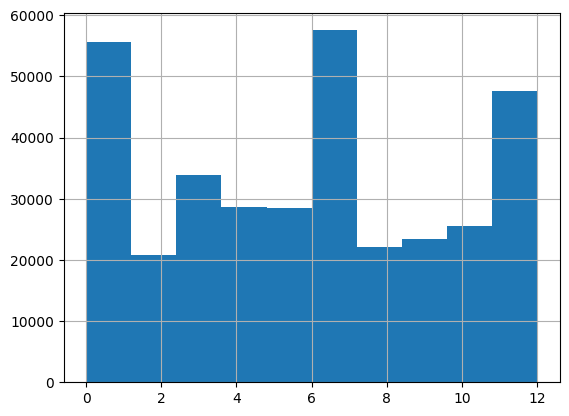

In [11]:
ax = data['registration_month'].hist()

In [12]:
data = data.drop(columns='registration_month')
CAT_FEATURES.remove('registration_month')

---

In [13]:
X = data.drop(columns='price')
y = data['price']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

## Обучение моделей

<div class="alert alert-danger">
<b>Комментарий ревьюера ❌:</b> %%time считает время выполнения ячейки. А нам нужно время обучения и предсказания.
    
Давай переходить на кросс валидацию, так мы сможем использовать всего две выборки в этом есть большой плюс, так как больше данных уйдет на обучение


+  https://machinelearningmastery.ru/5-reasons-why-you-should-use-cross-validation-in-your-data-science-project-8163311a1e79/
    
    
Воспользуемся GridSearchCV для автоматического подбора параметров, он максимизирует нашу метрику и ускорит подбор параметров. Данный метод работает на кросс валидации, так что, идеально нам подходит:
    
+  https://towardsdatascience.com/gridsearchcv-for-beginners-db48a90114ee
+  https://jeffspagnola.medium.com/the-basics-of-gridsearch-e9cc9da7578f

    
У GridSearchCV есть атрибут  ```cv_results_``` в котором хранится вся история подбора параметров;)

+  https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

P.S В конце проекта так же и по нему оставил код    
    
</div>

<div class="alert alert-info">
<b>Комментарий студента:</b>
    
- Про перекрёстную проверку: у нас датасет в 350к примеров, то есть приличного размера, а CV - это инструмент для тюнинга гиперпараметров в условиях малого количества данных. Почему здесь необходимо использовать CV, а нельзя обойтись обычной валидацией?

- https://machinelearningmastery.ru/5-reasons-why-you-should-use-cross-validation-in-your-data-science-project-8163311a1e79/ Очень плохой машинный перевод. Мне кажется, не стоит скидывать подобную статью новичкам, она может только запутать неопытного читателя. __Особенно часть про stacking.__
-
</div>

### CatBoost

In [15]:
gs_catboost = GridSearchCV(
    estimator=catboost.CatBoostRegressor(cat_features=CAT_FEATURES, verbose=0, random_state=RANDOM_STATE),
    param_grid={
        'learning_rate': [0,4, 0.5, 0.6],
        'n_estimators': [120, 130, 140, 150],
    },
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=ShuffleSplit(n_splits=5, test_size=0.25, random_state=RANDOM_STATE),
)
gs_catboost.fit(X_train, y_train)

E:\Projects\YandexPracticum\venv\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "E:\Projects\YandexPracticum\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "E:\Projects\YandexPracticum\venv\lib\site-packages\catboost\core.py", line 5730, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
  File "E:\Projects\YandexPracticum\venv\lib\site-packages\catboost

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=0.25, train_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x000001F2B89A3580>,
             n_jobs=-1,
             param_grid={'learning_rate': [0, 4, 0.5, 0.6],
                         'n_estimators': [120, 130, 140, 150]},
             scoring='neg_mean_squared_error')

In [16]:
print('Лучшие гиперпараметры:')
for param, value in gs_catboost.best_params_.items():
    print(f'{param}: {value}')

Лучшие гиперпараметры:
learning_rate: 0.5
n_estimators: 150


### LightGBM

In [17]:
gs_lgbm = GridSearchCV(
    estimator=lightgbm.LGBMRegressor(random_state=RANDOM_STATE),
    param_grid={
        'learning_rate': [0.4, 0.5, 0.6],
        'n_estimators': [170, 180, 190, 200],
    },
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=ShuffleSplit(n_splits=5, test_size=0.25, random_state=RANDOM_STATE),
)
gs_lgbm.fit(X_train, y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=0.25, train_size=None),
             estimator=LGBMRegressor(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.4, 0.5, 0.6],
                         'n_estimators': [170, 180, 190, 200]},
             scoring='neg_mean_squared_error')

In [18]:
print('Лучшие гиперпараметры:')
for param, value in gs_lgbm.best_params_.items():
    print(f'{param}: {value}')

Лучшие гиперпараметры:
learning_rate: 0.4
n_estimators: 200


### RandomForest

In [20]:
gs_rf = GridSearchCV(
    estimator=lightgbm.LGBMRegressor(
        boosting_type='rf',
        bagging_fraction=0.75,
        random_state=RANDOM_STATE,
        bagging_freq=2,
    ),
    param_grid={
        'n_estimators': [115],  # np.linspace(10, 150, num=5, dtype='int'),
        'max_depth': [9],  # [5, 6, 7, 8, 9, 10],
    },
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=ShuffleSplit(n_splits=5, test_size=0.25, random_state=RANDOM_STATE),
)
gs_rf.fit(X_train, y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=0.25, train_size=None),
             estimator=LGBMRegressor(bagging_fraction=0.75, bagging_freq=2,
                                     boosting_type='rf', random_state=42),
             n_jobs=-1, param_grid={'max_depth': [9], 'n_estimators': [115]},
             scoring='neg_mean_squared_error')

In [21]:
print('Лучшие гиперпараметры:')
for param, value in gs_rf.best_params_.items():
    print(f'{param}: {value}')

Лучшие гиперпараметры:
max_depth: 9
n_estimators: 115


## Анализ моделей

<div class="alert alert-danger">
<b>Комментарий ревьюера ❌:</b> перед тестированием необходимо оценить модели на кросс валидации, и найти лучшую модель опираясь на ряд показателей: fit time/predict/rmse. И после того как сравним модели уже проводить тестирование
    

</div>

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> 
    
Для кросс валидации:
    
```python
    cv_lr = cross_validate(<your code>)

    fit_time = cv_lr['fit_time'].mean()
    score_time = <your code>
    test_score = <your code>

    print('Время обучения: {},  время предсказания: {} и качество модели: {}'.format(fit_time, score_time, test_score))
```
    
    
Для GridSearchCV:
    
```python
    results = dt_model.cv_results_
    best_index = dt_model.best_index_

    fit_time = <your code>
    score_time = <your code>
    RMSE = <your code>

    print(f"Fit time: {fit_time}, Predict time: {score_time}, Best RMSE: {RMSE}")
    
```
</div>




In [22]:
def report(gscv):
    fit_time = gscv.cv_results_['mean_fit_time'].mean()
    score_time = gscv.cv_results_['mean_score_time'].mean()
    RMSE = (-gscv.cv_results_['mean_test_score'].mean()) ** 0.5

    print(f'Время обучения: {fit_time:.2f}, время предсказания: {score_time:.2f} и качество модели: {RMSE:.2f}\n')

In [23]:
for name, gscv in zip(['CatBoost', 'LightGBM', 'RandomForest'], [gs_catboost, gs_lgbm, gs_rf]):
    print(name)
    report(gscv)

CatBoost
Время обучения: 23.27, время предсказания: 0.07 и качество модели: nan

LightGBM
Время обучения: 2.91, время предсказания: 0.79 и качество модели: 1691.86

RandomForest
Время обучения: 4.76, время предсказания: 0.51 и качество модели: 2372.53



In [25]:
lgbm_model = gs_lgbm.best_estimator_
y_pred = lgbm_model.predict(X_test)

RMSE = mean_squared_error(y_test, y_pred) ** 0.5
RMSE

1653.8381140467395

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей

<font color='blue'><b>Итоговый комментарий ревьюера</b></font>
<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b>Михаил, получился хороший проект! 
    
Если есть  если есть какие либо вопросы я с удовольствием на них отвечу:) <br> Исправь, пожалуйста, замечания и жду проект на следующую проверку:) </div>
